# Variation of CpG beta values in the full dataset vs Tissue vs Clocks

TO DO:  
find the average of each Cpg in the full dataset  
find the average of each Cpg in the top 100 CpGs dataset  
compare the averages  

### 0. Load libraries

In [29]:
# Load the required libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu ,shapiro, kstest
import dask.dataframe as dd

### 1. Load & Prepare the data

In [2]:
# Load the full methylation dataset
complete_methylation_data = pd.read_csv('GSE223748_datBetaNormalized.csv')

In [161]:
complete_methylation_data.shape

(37554, 15045)

In [3]:
# Load the metadata
metadata = pd.read_csv('GSE223748_complete_metadata.csv')

In [4]:
# Load the methylation data for the top 100CpGs of each clock
clock_1_top100CpG = pd.read_csv('./Clocks Methylation Data/Clock1_Methylation_data_Top100.csv')
clock_2_top100CpG = pd.read_csv('./Clocks Methylation Data/Clock2_Methylation_data_Top100.csv')
clock_3_top100CpG = pd.read_csv('./Clocks Methylation Data/Clock3_Methylation_data_Top100.csv')
clock_1_2_3_top100CpG = pd.read_csv('./Clocks Methylation Data/Clock1_2_3_Overlap_Methylation_data_Top100.csv')
clock_2_3_top100CpG = pd.read_csv('./Clocks Methylation Data/Clock2_3_Overlap_Methylation_data_Top100.csv')

In [5]:
complete_methylation_data.head()

,Unnamed: 0,202897220093_R01C01,202897220093_R02C01,202897220093_R03C01,202897220093_R04C01,202897220093_R05C01,202897220093_R06C01,202897220093_R01C02,202897220093_R02C02,202897220093_R03C02,...,206139140103_R02C02,206139140103_R03C02,206139140103_R04C02,206139140103_R05C02,206139140103_R06C02,206139140104_R01C01,206139140104_R02C01,206139140104_R03C01,206139140104_R04C01,206139140104_R05C01
0,cg00000165,0.480990,0.483132,0.494042,0.505628,0.496484,0.486760,0.497341,0.482591,0.495475,...,0.140734,0.070563,0.060902,0.056785,0.054896,0.218780,0.141689,0.092939,0.085170,0.060552
1,cg00001209,0.934681,0.946624,0.940368,0.935963,0.926762,0.931264,0.941756,0.936942,0.940002,...,0.833588,0.872219,0.900707,0.929456,0.861758,0.828209,0.868502,0.825405,0.907443,0.909347
2,cg00001364,0.911639,0.907298,0.912401,0.901470,0.912350,0.910808,0.911290,0.910110,0.907811,...,0.808296,0.858634,0.840960,0.903902,0.914616,0.778192,0.805107,0.832695,0.889494,0.901459
3,cg00001582,0.060784,0.057917,0.055478,0.064311,0.060102,0.055498,0.056630,0.060347,0.066302,...,0.077506,0.087474,0.081258,0.067971,0.067423,0.069621,0.075440,0.065853,0.074909,0.074081
4,cg00002920,0.655778,0.628036,0.697029,0.690823,0.678101,0.615883,0.638421,0.641940,0.654358,...,0.719434,0.782699,0.701002,0.638727,0.755281,0.776376,0.799998,0.781141,0.698296,0.731993


In [6]:
metadata.head()

,SpeciesCommonName,SpeciesLatinName,Tissue,Sex,Age,Sample,GEO_ID
0,Olive baboon,Papio hamadryas,Cortex,Female,22.12,X202794570001_R01C01,GSM6981727
1,Olive baboon,Papio hamadryas,Cortex,Male,8.04,X202794570001_R01C02,GSM6981733
2,Olive baboon,Papio hamadryas,Cortex,Female,18.95,X202794570001_R02C01,GSM6981728
3,Olive baboon,Papio hamadryas,Cortex,Male,18.64,X202794570001_R02C02,GSM6981734
4,Olive baboon,Papio hamadryas,Cortex,Female,18.61,X202794570001_R03C01,GSM6981729


#### 1.1. Rectify the data:  
- remove the X on the sample names, so to match the metadata 
- rename the first col in the complete methylation df from Unnamed: 0 to Sample

In [7]:
# Drop the X on he the sample names in the metadata
metadata['Sample'] = metadata['Sample'].str.replace('X', '')

In [8]:
metadata.head()

,SpeciesCommonName,SpeciesLatinName,Tissue,Sex,Age,Sample,GEO_ID
0,Olive baboon,Papio hamadryas,Cortex,Female,22.12,202794570001_R01C01,GSM6981727
1,Olive baboon,Papio hamadryas,Cortex,Male,8.04,202794570001_R01C02,GSM6981733
2,Olive baboon,Papio hamadryas,Cortex,Female,18.95,202794570001_R02C01,GSM6981728
3,Olive baboon,Papio hamadryas,Cortex,Male,18.64,202794570001_R02C02,GSM6981734
4,Olive baboon,Papio hamadryas,Cortex,Female,18.61,202794570001_R03C01,GSM6981729


In [9]:
# Change Unnamed: 0 to CpG
complete_methylation_data.rename(columns={'Unnamed: 0': 'CpG'}, inplace=True)
complete_methylation_data.head()

,CpG,202897220093_R01C01,202897220093_R02C01,202897220093_R03C01,202897220093_R04C01,202897220093_R05C01,202897220093_R06C01,202897220093_R01C02,202897220093_R02C02,202897220093_R03C02,...,206139140103_R02C02,206139140103_R03C02,206139140103_R04C02,206139140103_R05C02,206139140103_R06C02,206139140104_R01C01,206139140104_R02C01,206139140104_R03C01,206139140104_R04C01,206139140104_R05C01
0,cg00000165,0.480990,0.483132,0.494042,0.505628,0.496484,0.486760,0.497341,0.482591,0.495475,...,0.140734,0.070563,0.060902,0.056785,0.054896,0.218780,0.141689,0.092939,0.085170,0.060552
1,cg00001209,0.934681,0.946624,0.940368,0.935963,0.926762,0.931264,0.941756,0.936942,0.940002,...,0.833588,0.872219,0.900707,0.929456,0.861758,0.828209,0.868502,0.825405,0.907443,0.909347
2,cg00001364,0.911639,0.907298,0.912401,0.901470,0.912350,0.910808,0.911290,0.910110,0.907811,...,0.808296,0.858634,0.840960,0.903902,0.914616,0.778192,0.805107,0.832695,0.889494,0.901459
3,cg00001582,0.060784,0.057917,0.055478,0.064311,0.060102,0.055498,0.056630,0.060347,0.066302,...,0.077506,0.087474,0.081258,0.067971,0.067423,0.069621,0.075440,0.065853,0.074909,0.074081
4,cg00002920,0.655778,0.628036,0.697029,0.690823,0.678101,0.615883,0.638421,0.641940,0.654358,...,0.719434,0.782699,0.701002,0.638727,0.755281,0.776376,0.799998,0.781141,0.698296,0.731993


#### 1.2. Calculate the mean of the CpGs in the datasets and add it?

In [10]:
#### Calculate the mean methylation for each CpG without overloading the memory and add it to the complete_methylation_data DataFrame

# Convert Pandas DataFrame to Dask DataFrame
dask_df = dd.from_pandas(complete_methylation_data, npartitions=10)  # Adjust npartitions as needed

# Calculate mean using Dask
complete_methylation_data['Mean'] = dask_df.iloc[:, 1:].mean(axis=1).compute()

In [11]:
complete_methylation_data.head()

,CpG,202897220093_R01C01,202897220093_R02C01,202897220093_R03C01,202897220093_R04C01,202897220093_R05C01,202897220093_R06C01,202897220093_R01C02,202897220093_R02C02,202897220093_R03C02,...,206139140103_R03C02,206139140103_R04C02,206139140103_R05C02,206139140103_R06C02,206139140104_R01C01,206139140104_R02C01,206139140104_R03C01,206139140104_R04C01,206139140104_R05C01,Mean
0,cg00000165,0.480990,0.483132,0.494042,0.505628,0.496484,0.486760,0.497341,0.482591,0.495475,...,0.070563,0.060902,0.056785,0.054896,0.218780,0.141689,0.092939,0.085170,0.060552,0.297239
1,cg00001209,0.934681,0.946624,0.940368,0.935963,0.926762,0.931264,0.941756,0.936942,0.940002,...,0.872219,0.900707,0.929456,0.861758,0.828209,0.868502,0.825405,0.907443,0.909347,0.824033
2,cg00001364,0.911639,0.907298,0.912401,0.901470,0.912350,0.910808,0.911290,0.910110,0.907811,...,0.858634,0.840960,0.903902,0.914616,0.778192,0.805107,0.832695,0.889494,0.901459,0.838070
3,cg00001582,0.060784,0.057917,0.055478,0.064311,0.060102,0.055498,0.056630,0.060347,0.066302,...,0.087474,0.081258,0.067971,0.067423,0.069621,0.075440,0.065853,0.074909,0.074081,0.057634
4,cg00002920,0.655778,0.628036,0.697029,0.690823,0.678101,0.615883,0.638421,0.641940,0.654358,...,0.782699,0.701002,0.638727,0.755281,0.776376,0.799998,0.781141,0.698296,0.731993,0.521763


!!! Need to add all the clocks here

In [12]:
#### Calculate the mean methylation for each CpG in the top 100 CpGs of each clock and it to the respective DataFrame without overloading the memory
dask2_df = dd.from_pandas(clock_1_top100CpG, npartitions=10)
clock_1_top100CpG['Mean'] = dask2_df.iloc[:, 1:].mean(axis=1)

In [13]:
clock_1_top100CpG.head()

,CpG,X203203210100_R01C01,X203203210100_R02C01,X203203210100_R03C01,X203203210100_R04C01,X203203210100_R05C01,X203203210100_R06C01,X203203210100_R01C02,X203203210100_R02C02,X203203210100_R03C02,...,X203203210013_R04C01,X203203210013_R05C01,X203203210013_R06C01,X203203210013_R01C02,X203203210013_R02C02,X203203210013_R03C02,X203203210013_R04C02,X203203210013_R05C02,X203203210013_R06C02,Mean
0,cg00249943,0.739928,0.863397,0.783507,0.855604,0.862688,0.873553,0.863869,0.848483,0.854513,...,0.893357,0.875352,0.925570,0.913479,0.924512,0.890197,0.907542,0.919868,0.879912,0.880300
1,cg00362836,0.915980,0.922532,0.903346,0.911423,0.912474,0.924406,0.909988,0.904889,0.885616,...,0.691954,0.853661,0.595721,0.711241,0.733125,0.688113,0.691154,0.833698,0.769115,0.789089
2,cg00513357,0.750772,0.839959,0.800842,0.862782,0.851387,0.518595,0.474646,0.806673,0.814443,...,0.510468,0.845441,0.453870,0.658472,0.654964,0.831220,0.584324,0.791753,0.764990,0.756022
3,cg00587168,0.514703,0.537805,0.585054,0.572860,0.658180,0.708419,0.754837,0.504294,0.575997,...,0.681482,0.675833,0.684621,0.600571,0.645771,0.672322,0.649559,0.561802,0.446781,0.605676
4,cg00593462,0.645589,0.647000,0.654486,0.625022,0.659689,0.505178,0.568180,0.656799,0.597615,...,0.739847,0.752494,0.626911,0.780230,0.821440,0.729890,0.617591,0.711748,0.568700,0.715046


#### 1.3. Create Tissue specific methylation datasets

In [20]:
# Tissues dataframe 

tissues_df = metadata[['Sample', 'Tissue']]
tissues_df

,Sample,Tissue
0,202794570001_R01C01,Cortex
1,202794570001_R01C02,Cortex
2,202794570001_R02C01,Cortex
3,202794570001_R02C02,Cortex
4,202794570001_R03C01,Cortex
...,...,...
15038,204529320081_R02C02,Liver
15039,204529320081_R03C01,Liver
15040,204529320081_R04C01,Liver
15041,204529320081_R04C02,Ear


In [41]:
# Split the Tissues df into tissue specific dataframes
tissues = tissues_df['Tissue'].unique()

for tissue in tissues:
    globals()['{}_df'.format(tissue)] = tissues_df[tissues_df['Tissue'] == tissue].copy()


In [49]:
Blood_df

,Sample,Tissue
13,202794570002_R01C02,Blood
16,202794570002_R03C02,Blood
18,202794570002_R04C02,Blood
20,202794570002_R05C02,Blood
21,202794570002_R06C01,Blood
...,...,...
14685,205987790065_R06C01,Blood
14686,205987790065_R06C02,Blood
15014,206139140104_R01C02,Blood
15016,206139140104_R02C02,Blood


In [50]:
# Filter through the complete methylation data to create tissue-specific datasets and save them as CSV files

# Create a folder to store tissue-specific methylation datasets if it doesn't exist
folder_name = "Tissue Methylation"
os.makedirs(folder_name, exist_ok=True)

# Split the Tissues df into tissue specific dataframes
tissues = tissues_df['Tissue'].unique()

# Create tissue-specific dataframes and filter through the complete methylation data
for tissue in tissues:
    # Create tissue-specific dataframe
    tissue_df = tissues_df[tissues_df['Tissue'] == tissue].copy()
    
    # Get the sample names for the current tissue
    sample_names = tissue_df['Sample']
    
    # Filter the complete methylation dataset to include only the samples associated with the current tissue
    globals()['{}_methylation_dataset'.format(tissue)] = complete_methylation_data[sample_names].copy()
    
    # Save the tissue-specific methylation dataset as a CSV file
    file_name = os.path.join(folder_name, "{}_methylation_dataset.csv".format(tissue))
    globals()['{}_methylation_dataset'.format(tissue)].to_csv(file_name, index=False)




In [14]:
# Load the tissue-specific methylation datasets from the saved CSV files (so the whole script can be run from here)

folder_name = "Tissue Methylation"
tissue_files = os.listdir(folder_name)

# Load each CSV file into its own dataframe
for file in tissue_files:
    # Extract tissue name from file name
    tissue = file.split("_")[0]
    
    # Load CSV file into dataframe
    file_path = os.path.join(folder_name, file)
    globals()['{}_methylation_dataset'.format(tissue)] = pd.read_csv(file_path)

In [17]:
Blood_methylation_dataset

,202794570002_R01C02,202794570002_R03C02,202794570002_R04C02,202794570002_R05C02,202794570002_R06C01,202794570002_R06C02,202794570020_R01C01,202794570020_R01C02,202794570020_R02C01,202794570020_R02C02,...,205987790065_R03C02,205987790065_R04C01,205987790065_R04C02,205987790065_R05C01,205987790065_R05C02,205987790065_R06C01,205987790065_R06C02,206139140104_R01C02,206139140104_R02C02,206139140104_R06C01
0,0.480598,0.480727,0.471287,0.491907,0.470413,0.494566,0.481661,0.491640,0.480910,0.497053,...,0.407053,0.367825,0.401268,0.364609,0.347046,0.355744,0.369246,0.486253,0.495817,0.494882
1,0.949652,0.920081,0.939281,0.882610,0.945128,0.936300,0.946920,0.938225,0.923380,0.948519,...,0.840539,0.853517,0.825651,0.884960,0.877434,0.903645,0.887097,0.930023,0.867957,0.863826
2,0.893691,0.866378,0.903879,0.855325,0.894495,0.898212,0.884243,0.904272,0.892112,0.890944,...,0.891103,0.900207,0.861802,0.893173,0.897086,0.889955,0.894398,0.853597,0.878107,0.871956
3,0.046624,0.050458,0.050236,0.053441,0.046996,0.049230,0.043981,0.050063,0.047062,0.052592,...,0.055695,0.068869,0.054473,0.056021,0.055213,0.056673,0.058086,0.025566,0.036963,0.030652
4,0.112284,0.150901,0.133024,0.127054,0.129705,0.134837,0.138700,0.109279,0.142278,0.126254,...,0.065887,0.050233,0.062335,0.056261,0.055913,0.063233,0.062313,0.498621,0.489322,0.506145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37549,0.493235,0.482766,0.484120,0.498580,0.497062,0.498336,0.500621,0.493511,0.501958,0.499716,...,0.483842,0.493286,0.490871,0.491680,0.492173,0.477409,0.513352,0.492368,0.495466,0.462430
37550,0.557094,0.539500,0.534311,0.548555,0.528250,0.539516,0.555038,0.559750,0.562682,0.550175,...,0.506287,0.516968,0.503029,0.497442,0.507444,0.502575,0.496206,0.523383,0.515940,0.496514
37551,0.497131,0.496431,0.515023,0.494241,0.500000,0.492019,0.489759,0.501006,0.495864,0.502967,...,0.505320,0.480771,0.488759,0.498497,0.477996,0.485193,0.479287,0.441208,0.446352,0.426978
37552,0.502601,0.497322,0.505302,0.493309,0.464286,0.490885,0.516049,0.496675,0.484289,0.502761,...,0.488582,0.484912,0.485866,0.462358,0.510939,0.493083,0.471959,0.480694,0.483949,0.484415


In [43]:
# Create a data frame with the name of the tissue datastets and the number of samples in each dataset
tissue_sample_count = []

for tissue in tissues:
    sample_count = globals()['{}_methylation_dataset'.format(tissue)].shape[1]
    tissue_sample_count.append({'Tissue': tissue, 'Sample Count': sample_count})

tissue_sample_count_df = pd.DataFrame(tissue_sample_count)

# Sort the data frame by sample count in descending order
tissue_sample_count_df.sort_values(by='Sample Count', ascending=False, inplace=True)
tissue_sample_count_df

,Tissue,Sample Count
2,Blood,4554
3,Skin,2754
1,Liver,2156
20,Ear,769
0,Cortex,714
...,...,...
41,Larynx,2
35,MitralValve,2
51,Dermis,1
11,Thyroid,1


In [47]:
# Select the following tissues in the tissue sample count df: Aorta, Bladder, Cartilage, Crypts, Gut, Kidney, Oocytes, Pancreas, Villi
tissue_sample_count_df[tissue_sample_count_df['Tissue'].isin(['Aorta', 'Bladder', 'Cartilage', 'Crypts', 'Gut', 'Kidney', 'Oocytes', 'Pancreas', 'Villi'])]



,Tissue,Sample Count
56,Aorta,20
26,Bladder,15
45,Cartilage,2
66,Crypts,11
69,Gut,11
8,Kidney,327
10,Pancreas,2
65,Villi,10


In [44]:
# filter through tissue sample count df and select only tissues with less than 3 samples
tissue_sample_count_df[tissue_sample_count_df['Sample Count'] < 3]

,Tissue,Sample Count
31,TemporalCortex,2
10,Pancreas,2
24,Ileum,2
28,Duodenum,2
32,Lamina,2
43,Suspensory,2
33,OccipitalCortex,2
36,AdrenalCortex,2
37,Sacrocaudalis,2
50,Epidermis,2


### 2. Compare the mean CpG beta values

#### 2.1 Compare the mean beta value of each CpG in the full dataset with the mean beta value of each tissue in the tissue specific datasets.

##### 2.1.1. Check the distribution of the mean beta values of the CpGs in the full dataset and the tissue specific datasets

In [16]:
# Checking if the complete methylation data is normally distributed using the Shapiro-Wilk test

# make a copy of the complete methylation data without the first and last columns (CpG and Mean)
complete_methylation_data_copy = complete_methylation_data.iloc[:,1:-1].copy()

dask3_df = dd.from_pandas(complete_methylation_data_copy, npartitions=10)

shapiro_stat, shapiro_p = shapiro(dask3_df)
ks_stat, ks_p = kstest(dask3_df, 'norm')
# Calculate summary statistics from the arrays generated by the Kolmogorov-Smirnov test
ks_stat_summary = np.max(ks_stat)
ks_p_summary = np.max(ks_p)

print(f'The Shapiro-Wilk test statistic is {shapiro_stat} and the p-value is {shapiro_p}')
print(f'The Kolmogorov-Smirnov test statistic is {ks_stat_summary} and the p-value is {ks_p_summary}')

C:\Users\Catia Antunes\AppData\Local\Temp\ipykernel_8176\3856885881.py:5: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 564924822.
  shapiro_stat, shapiro_p = shapiro(dask3_df)


The Shapiro-Wilk test statistic is 0.877909275208784 and the p-value is 2.8328101841452437e-87
The Kolmogorov-Smirnov test statistic is 0.5097103189192183 and the p-value is 0.0


In [21]:
# Checking if the tissue methylation datasets are normally distributed. Because the dataset is large, we'll use both the Shapiro-Wilk test and the Kolmogorov-Smirnov test.

# The Shapiro-Wilk test is more powerful for small sample sizes, while the Kolmogorov-Smirnov test is more powerful for large sample sizes. 
# We'll use both tests to ensure that the results are consistent.

# Get the list of unique tissues
tissues = tissues_df['Tissue'].unique()

# Create an empty list to store normality test results
normality_results = []

# Loop through each tissue-specific dataset
for tissue in tissues:
    # Extract the tissue-specific dataset
    dataset = globals()['{}_methylation_dataset'.format(tissue)].iloc[:, 1:-1] # from the second column to the second last column because the last column is the mean
    
    # Check if the dataset has at least 3 data points and skip the rest of the analysis if it doesn't   
    if len(dataset.columns) < 3:
        normality_results.append({'Tissue': tissue, 'Shapiro-Wilk test stat': 'N/A', 'Shappiro-Wilk P-value': 'N/A', 'Kolmogorov-Smirnov test stat': 'N/A', 'Kolmogorov-Smirnov P-value': 'N/A'})
        continue
    
    # Suppress specific warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Perform Shapiro-Wilk test for normality if dataset has at least 3 data points
        shapiro_stat, shapiro_p = shapiro(dataset)
    
    # Perform Kolmogorov-Smirnov test for normality against the normal distribution
    ks_stat, ks_p = kstest(dataset, 'norm')
    
    # Calculate summary statistics from the arrays generated by the Kolmogorov-Smirnov test
    ks_stat_summary = np.max(ks_stat)
    ks_p_summary = np.max(ks_p)
    
    # Append normality test results to the list
    normality_results.append({'Tissue': tissue, 'Shapiro-Wilk test stat': shapiro_stat, 'Shappiro-Wilk P-value': shapiro_p, 'Kolmogorov-Smirnov test stat': ks_stat_summary, 'Kolmogorov-Smirnov P-value': ks_p_summary})

normality_results_df = pd.DataFrame(normality_results)

normality_results_df.head()

,Tissue,Shapiro-Wilk test stat,Shappiro-Wilk P-value,Kolmogorov-Smirnov test stat,Kolmogorov-Smirnov P-value
0,Cortex,0.896878,0.0,0.503303,0.0
1,Liver,0.884535,0.0,0.506721,0.0
2,Blood,0.838886,0.0,0.508058,0.0
3,Skin,0.887628,0.0,0.50971,0.0
4,Muscle,0.905881,0.0,0.506578,0.0


In [22]:
# Check how many of the datasets are normally distributed based on the Shapiro-Wilk test and the Kolmogorov-Smirnov tests

# Make a copy of the normality results dataframe
normality_results_df_copy = normality_results_df.copy()

# Drop rows with missing values
normality_results_df_copy.dropna(inplace=True)

# Check if there are still missing values
if normality_results_df_copy.isnull().any().all():
    print("There are still missing values in the normality test results. Please check the data and rerun the analysis.")
    
else:
    # Convert columns to float
    normality_results_df_copy['Shappiro-Wilk P-value'] = pd.to_numeric(normality_results_df_copy['Shappiro-Wilk P-value'], errors='coerce')
    normality_results_df_copy['Kolmogorov-Smirnov P-value'] = pd.to_numeric(normality_results_df_copy['Kolmogorov-Smirnov P-value'], errors='coerce')

    # Drop rows with NaN values
    normality_results_df_copy.dropna(subset=['Shappiro-Wilk P-value', 'Kolmogorov-Smirnov P-value'], inplace=True)

    # Count the number of tissues that are normally distributed based on the Shapiro-Wilk test
    shapiro_normal_tissues = len(normality_results_df_copy[normality_results_df_copy['Shappiro-Wilk P-value'] >= 0.05]) # a p-value > 0.05 indicates normality

    # Count the number of tissues that are normally distributed based on the Kolmogorov-Smirnov test
    ks_normal_tissues = len(normality_results_df_copy[normality_results_df_copy['Kolmogorov-Smirnov P-value'] >= 0.05]) # a p-value > 0.05 indicates normality

    print("Number of tissues that are normally distributed based on the Shapiro-Wilk test:", shapiro_normal_tissues)  
    print("Number of tissues that are normally distributed based on the Kolmogorov-Smirnov test:", ks_normal_tissues)



Number of tissues that are normally distributed based on the Shapiro-Wilk test: 0
Number of tissues that are normally distributed based on the Kolmogorov-Smirnov test: 0


Now that we have checked the datasets are not normally distributed, we can use the Mann-Whitney U test to compare the mean beta values of the CpGs in the full dataset with the mean beta values of the CpGs in the tissue specific datasets.

In [27]:
### Compare the mean methylation values between the complete dataset and each tissue-specific dataset using Pearson correlation, t-test, and Mann-Whitney U test

# Create an empty list to store comparison results
comparison_results = []

# Loop through each tissue-specific dataset
for tissue in tissues:
    # Calculate the mean methylation value for each CpG site in the tissue-specific dataset
    tissue_mean = globals()['{}_methylation_dataset'.format(tissue)].iloc[:, 1:].mean(axis=1)
    
    # Calculate Pearson correlation coefficient between the mean methylation values of the complete dataset and the tissue-specific dataset
    correlation = complete_methylation_data['Mean'].corr(tissue_mean)
    
    # Perform t-test to assess the significance of the difference in mean methylation values between the complete dataset and the tissue-specific dataset
    t_statistic, p_value_ttest = ttest_ind(complete_methylation_data['Mean'], tissue_mean)
    
    # Perform Mann-Whitney U test to assess the significance of the difference in mean methylation values between the complete dataset and the tissue-specific dataset
    u_statistic, p_value_mannwhitneyu = mannwhitneyu(complete_methylation_data['Mean'], tissue_mean)
    
    # Append comparison results to the list
    comparison_results.append({'Tissue': tissue, 'Pearsons Correlation': correlation, 'P-value (t-test)': p_value_ttest, 'P-value (Mann-Whitney U test)': p_value_mannwhitneyu})

# Convert the list of dictionaries to a DataFrame
comparison_results_df = pd.DataFrame(comparison_results)

# sort by P-value (t-test) in ascending order
comparison_results_df.sort_values(by='P-value (Mann-Whitney U test)', ascending=True, inplace=True)

# Print or further analyze the comparison results
comparison_results_df


,Tissue,Pearsons Correlation,P-value (t-test),P-value (Mann-Whitney U test)
13,LymphNode,0.894920,3.079281e-150,0.000000e+00
23,Pituitary,0.817087,9.974722e-279,8.694280e-262
57,MacrophageBoneMarrow,0.858122,1.137263e-42,5.750540e-256
50,Epidermis,0.809864,1.312234e-29,1.936081e-247
60,iPSC,0.898506,1.449705e-125,1.022211e-182
...,...,...,...,...
8,Kidney,0.950604,1.866943e-06,3.508246e-01
65,Villi,0.881733,3.159721e-19,4.378491e-01
7,Testis,NaN,NaN,NaN
11,Thyroid,NaN,NaN,NaN


In [117]:
# Check which tissues have NaN values in the comparison results
comparison_results_df[comparison_results_df.isnull().any(axis=1)]


,Tissue,Pearsons Correlation,P-value (t-test),P-value (Mann-Whitney U test)
7,Testis,NaN,NaN,NaN
11,Thyroid,NaN,NaN,NaN
51,Dermis,NaN,NaN,NaN


In [145]:
# # Drop rows with missing values
comparison_results_df.dropna(inplace=False)

In [152]:
comparison_results_df

,Tissue,Pearsons Correlation,P-value (t-test),P-value (Mann-Whitney U test)
13,LymphNode,0.894920,3.079281e-150,0.000000e+00
23,Pituitary,0.817087,9.974722e-279,8.694280e-262
57,MacrophageBoneMarrow,0.858122,1.137263e-42,5.750540e-256
50,Epidermis,0.809864,1.312234e-29,1.936081e-247
60,iPSC,0.898506,1.449705e-125,1.022211e-182
...,...,...,...,...
66,Crypts,0.827641,2.563349e-23,3.234897e-02
26,Bladder,0.843873,7.401256e-28,1.304875e-01
52,Oocyte,0.832893,1.954367e-30,1.530962e-01
8,Kidney,0.950604,1.866943e-06,3.508246e-01


In [147]:
# Count the number of Tissues for which the P-value (Mann-Whitney U Test) is less than 0.05
significant_tissues = comparison_results_df[comparison_results_df['P-value (Mann-Whitney U test)'] <= 0.05].shape[0]
significant_tissues

63

In [148]:
# List of tissues with significant differences in mean methylation values compared to the complete dataset
significant_tissues_list = comparison_results_df[comparison_results_df['P-value (Mann-Whitney U test)'] <= 0.05]['Tissue'].tolist()
significant_tissues_list


['LymphNode',
 'Pituitary',
 'MacrophageBoneMarrow',
 'Epidermis',
 'iPSC',
 'Keratinocyte',
 'MacrophagePeritoneal',
 'Fibroblast',
 'Hippocampus',
 'Blood',
 'Placenta',
 'Tail',
 'MitralValve',
 'Fetus',
 'BoneMarrow',
 'Mammary',
 'Ileum',
 'Tendon',
 'Neocortex',
 'HematopoieticStem.Progenitor.LSK',
 'Astrocyte',
 'Jejunum',
 'Brain',
 'Cecum',
 'Spleen',
 'Ovaries',
 'EndothelialCell',
 'Substantia nigra',
 'OccipitalCortex',
 'Sacrocaudalis',
 'Suspensory',
 'Larynx',
 'Duodenum',
 'WholeBrain',
 'Muscle',
 'AdrenalCortex',
 'ParietalCortex',
 'Hypothalamus',
 'Lamina',
 'Blubber',
 'Ear',
 'Lung',
 'TemporalCortex',
 'DifferentiatedBloodCells',
 'Cerebellum',
 'Striatum',
 'Adipose',
 'Maybe.Larynx',
 'SpinalCord',
 'Heart',
 'Cortex',
 'ES',
 'Skin',
 'Uterus',
 'SVZ',
 'Liver',
 'HematopoieticStemCells',
 'FrontalCortex',
 'Gut',
 'Cartilage',
 'Pancreas',
 'Aorta',
 'Crypts']

In [153]:
## Check which tissues are not in the significant tissues list  
tissues_not_significant = [tissue for tissue in tissues if tissue not in significant_tissues_list]
tissues_not_significant

# It was printing 7 tissues instead of 4 (Dermis, Thyroid and Testis should not appear)

['Testis', 'Kidney', 'Thyroid', 'Bladder', 'Dermis', 'Oocyte', 'Villi']

63 Tissues present a significant difference in the mean beta values and the mean beta values of the complete dataset.

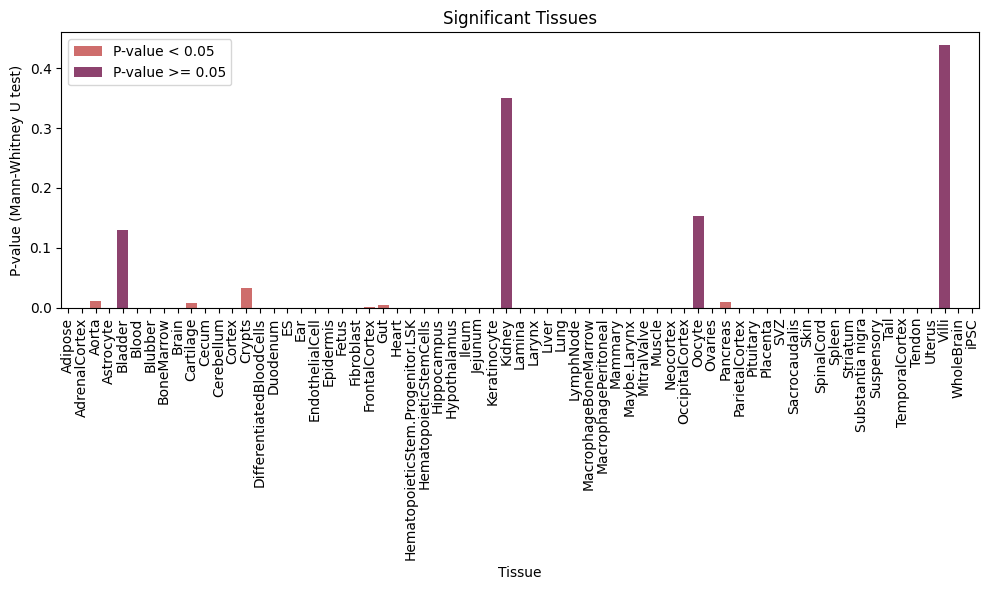

In [166]:
# 1. Bar Plot for Significant Tissues (Man-Whitney U Test only)

# Sort the dataframe by 'Tissue' column
comparison_results_df_sorted = comparison_results_df.sort_values(by='Tissue')

# Define color pallete
sns.color_palette("dark:#5A9_r", as_cmap=True)
sns.color_palette("flare", as_cmap=True)


# define hue based on p-value threshold for the sorted dataframe
hue = np.where(comparison_results_df_sorted['P-value (Mann-Whitney U test)'] <= 0.05, 'P-value < 0.05', 'P-value >= 0.05')

# Bar Plot for Significant Tissues
plt.figure(figsize=(10, 6))
sns.barplot(x='Tissue', y='P-value (Mann-Whitney U test)', data=comparison_results_df_sorted, hue=hue, palette="flare")

plt.title('Significant Tissues')
plt.xlabel('Tissue')
plt.ylabel('P-value (Mann-Whitney U test)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [160]:
# print the tissues with a p-value higher than 0 and show only the man-whitney u test p-value
comparison_results_df[comparison_results_df['P-value (Mann-Whitney U test)'] > 0.001][['Tissue', 'P-value (Mann-Whitney U test)']]


,Tissue,P-value (Mann-Whitney U test)
27,FrontalCortex,0.001233
69,Gut,0.005460
45,Cartilage,0.007517
10,Pancreas,0.009420
56,Aorta,0.011961
66,Crypts,0.032349
26,Bladder,0.130488
52,Oocyte,0.153096
8,Kidney,0.350825
65,Villi,0.437849


In [116]:
# Check the p-values for the problematic tissues
problematic_tissues = ['Dermis', 'Thyroid', 'Testis']
for tissue in problematic_tissues:
    p_value = comparison_results_df_sorted.loc[comparison_results_df_sorted['Tissue'] == tissue, 'P-value (Mann-Whitney U test)'].values
    print(f"P-value for {tissue}: {p_value}")


P-value for Dermis: [nan]
P-value for Thyroid: [nan]
P-value for Testis: [nan]


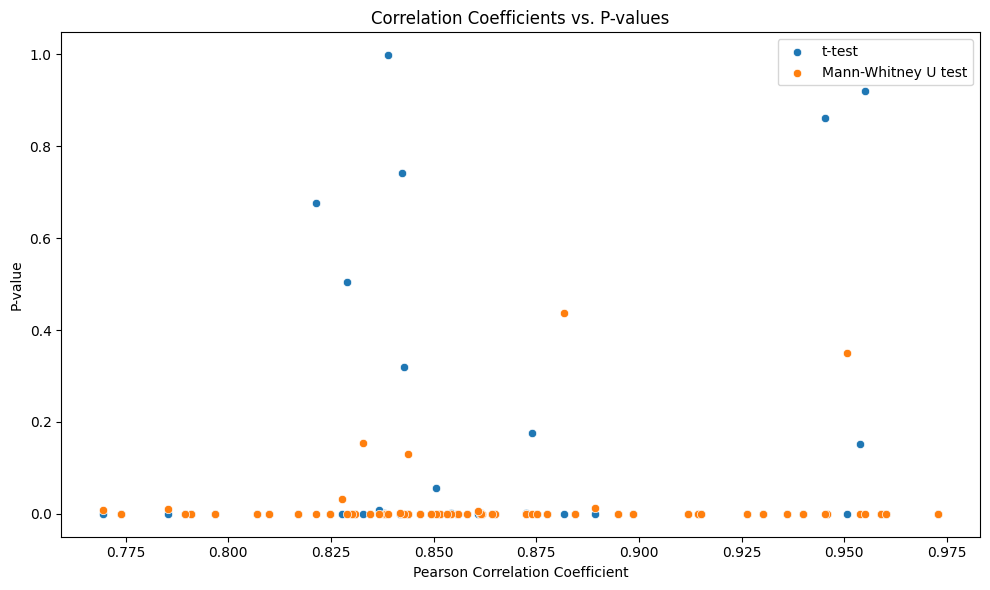

In [165]:
# 2. Scatter Plot for Correlation Coefficients and P-values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Pearsons Correlation', y='P-value (t-test)', data=comparison_results_df, label='t-test')
sns.scatterplot(x='Pearsons Correlation', y='P-value (Mann-Whitney U test)', data=comparison_results_df, label='Mann-Whitney U test')
plt.title('Correlation Coefficients vs. P-values')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('P-value')
plt.legend()
plt.tight_layout()
plt.show()

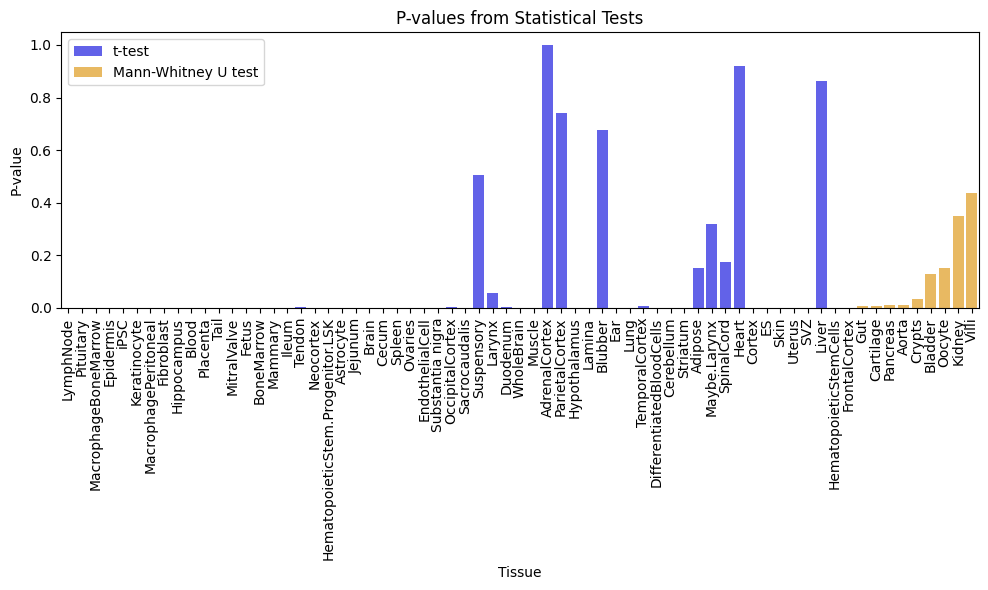

In [162]:
# 3. Bar Plot for P-values
plt.figure(figsize=(10, 6))
sns.barplot(x='Tissue', y='P-value (t-test)', data=comparison_results_df, color='blue', alpha=0.7, label='t-test')
sns.barplot(x='Tissue', y='P-value (Mann-Whitney U test)', data=comparison_results_df, color='orange', alpha=0.7, label='Mann-Whitney U test')
plt.title('P-values from Statistical Tests')
plt.xlabel('Tissue')
plt.ylabel('P-value')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

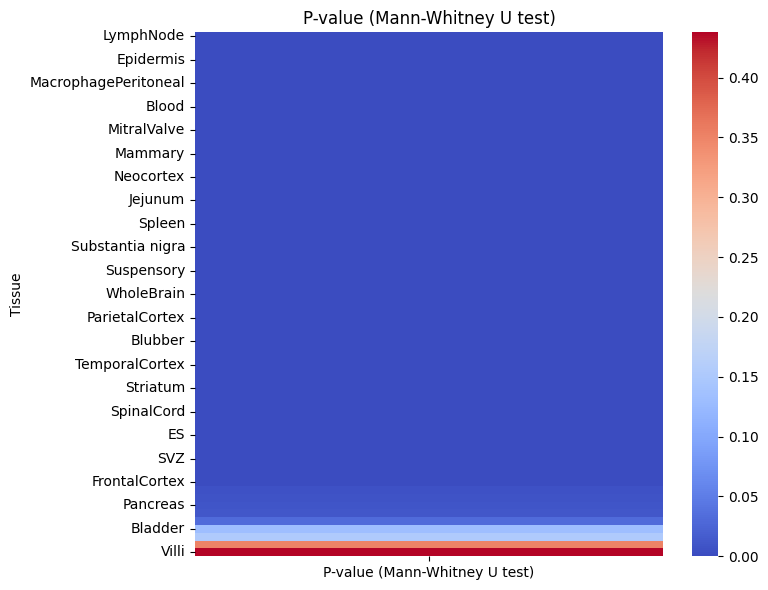

In [163]:
# 4. Heatmap for P-values
p_values_df = comparison_results_df[['P-value (Mann-Whitney U test)']].copy()
p_values_df.index = comparison_results_df['Tissue']
plt.figure(figsize=(8, 6))
sns.heatmap(p_values_df, annot=False, cmap='coolwarm', fmt=".2g")
plt.title('P-value (Mann-Whitney U test)')
plt.tight_layout()
plt.show()

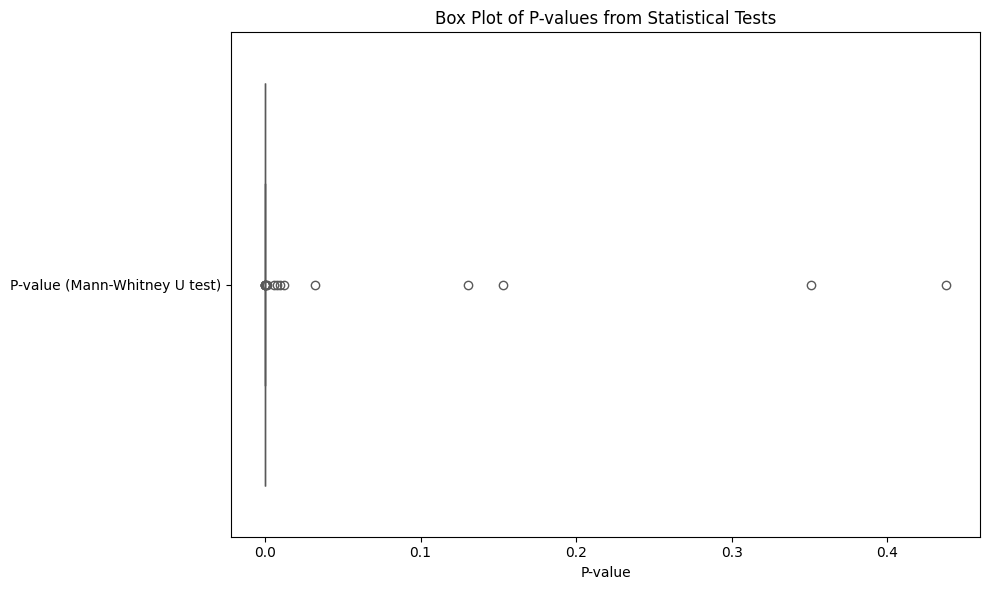

In [164]:
# 5. Box Plot of the p-values
plt.figure(figsize=(10, 6))
sns.boxplot(data=p_values_df, orient='h', palette='Set2')
plt.title('Box Plot of P-values from Statistical Tests')
plt.xlabel('P-value')
plt.tight_layout()
plt.show()

### NOT DONE: Compare the mean beta values of each CpG in the full dataset with the mean beta values of each tissue in genera and each tissue in the top 100 cpgs identified by the clocks.